# Introduction
This notebook has been produced during the course WSBIM2243, given by Benoit Macq (UCLouvain, Belgium).
Its main objective is to provide an introduction to medical image processing and more specifically to mammography. The main steps are summarized below : 
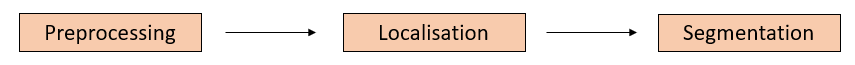
The notebook is divided in 3 chapters: 
* **Chapter 1 : Data preparation**, with a tutorial on how to download and process the data from INbreast dataset.
* **Chatper 2 : Localisation**, with features extraction from images and machine learning models training to detect tumours.
* **Chapter 3 : Segmentation**, with a semi-automatic approach to segment malignant masses.

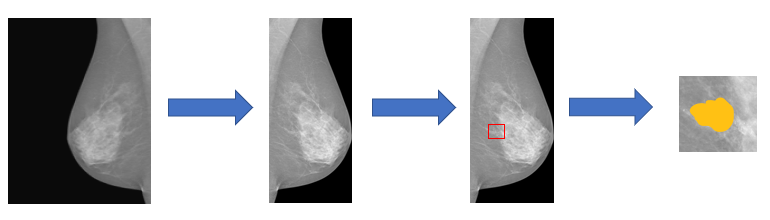

To facilitate the use of this jupyter notebook, we use Docker to containerise it (for example, https://u.group/thinking/how-to-put-jupyter-notebooks-in-a-dockerfile/, with the image containing opencv-python from https://hub.docker.com/r/jjanzic/docker-python3-opencv).

**Structure of the project folders**
* **notebook.ipynb** : current notebook.
* **requirements.txt** : python libraries.
* **sample data** : folder with a sample of the processed INbreast dataset.
    * sample_descrip tion.csv : ".csv" file with the file id, BIRADS classification and bounding boxes coordinates of a tumour (if any).
    * mammo : folder with ".png" mammograms (processed, see otsu thresholding in chapter 1).
    * mask : folder with ".png" masks (same size as the corresponding mammograms in the folder mammo.
    * unprocessed_mammo : folder with ".png" mammograms without the preprocessing presented in chapter 1 (raw data).
    * patch : folder with ".png" patches (see step 4 chapter 1).
* **features** : folder with some features used in chapter 2 to train classification machine learning models.

# Chapter 1 : Data preparation
We will use the mammograms from the publicly available INbreast dataset(*Moreira IC, Amaral I, Domingues I, Cardoso A, Cardoso MJ, Cardoso JS. INbreast: toward a full-field digital mammographic database. Acad Radiol. 2012 Feb;19(2):236-48. doi: 10.1016/j.acra.2011.09.014. Epub 2011 Nov 10. PMID: 22078258.*) from Centro Hospitalar de S. Joao ,Breast Centre, Porto. This dataset is one of the most used full-field digital mammography dataset. Another known dataset is CBIS-DDSM (available for example here : https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM) but it contained digitized mammography.

The main steps of this chapter are summarised below:
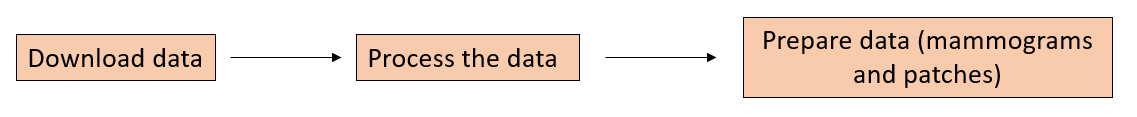

In [5]:
# import
import cv2 as cv
import pandas as pd
import pydicom
import os
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#### Step 1 : Download the dataset
Once we downloaded the dataset, we observe that the folder contains several folders and files. We will mainly use the folder containing the mammogram (DICOM format) and the CSV file containing the description of each mammogram.

If you do not want to download the dataset, you can still run this notebook with the sample available in the folder "sample data". All experiments below can be done with these mammograms.

#### Step 2 : Understand the dataset
It is important to understand the dataset and understand what we want to do. Here is for example different shapes that a mass can take in a breast (Source : *Singh, Jai & Nagarajan, Bagavathi. (2012). Automatic diagnosis of mammographic abnormalities based on hybrid features with learning classifier. Computer methods in biomechanics and biomedical engineering. 16. 10.1080/10255842.2011.639015.*) 

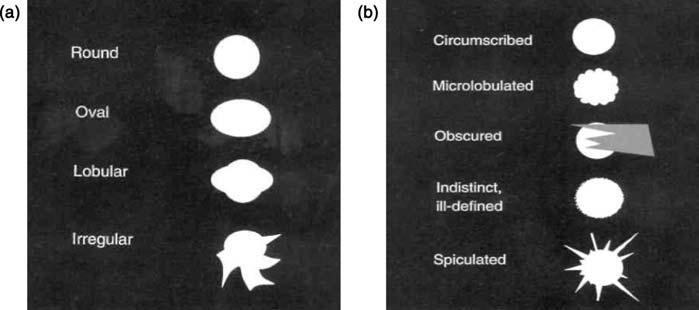

The more irregular the shape, the more likely the mass is to be malignant. This gives us clues as to which features we will focus on in future applications. For more details on what may be a tumor, see : *H. Berment, V. Becette, M.Mohallem, F. Ferreira, P. Chérel, Masses in mammography: What are the underlying anatomopathological lesions?, Diagnostic and Interventional Imaging, Volume 95, Issue 2, 2014, Pages 124-133, ISSN 2211-5684, https://doi.org/10.1016/j.diii.2013.12.010.*


Now we can look at what we downloaded. We can observe that : there is 2 different sizes (3328x4084 and 2560x3328), the images are quite big and there is a large amount of black pixels.

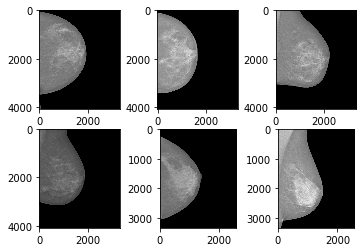

In [4]:
data_folder = 'sample data' # folder with a sample of the available data
f, axarr = plt.subplots(2,3)
c = 1
for i in range(2):
    for j in range(3):
        image = plt.imread(os.path.join(data_folder,'unprocessed_mammo','0000000'+str(c)+'.png'))
        axarr[i,j].imshow(image, cmap='gray')
        c += 1

#### Step 3 : Preprocessing 
Some mammograms contain a lot of dark pixels, we propose a method to determine the interesting area and cut off the areas without information. We use the Otsu's method (*Otsu, N. (1979) A Threshold Selection Method from Gray-Level Histogram. IEEE Transactions on System Man Cybernetics, 9, 62-66. http://dx.doi.org/10.1109/TSMC.1979.4310076*). It returns a single intensity threshold that separate pixels into two classes, foreground and background.

Example (original mammogram and after otsu thresholding)

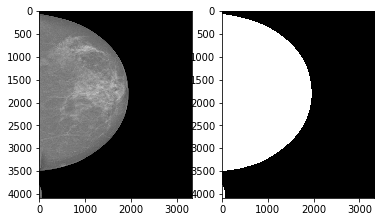

In [8]:
image = plt.imread('sample data//unprocessed_mammo//00000001.png')*255
image = np.uint8(image)
blur = cv.GaussianBlur(image,(5,5),0)
_, breast_mask = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image, cmap='gray')
axarr[1].imshow(breast_mask, cmap='gray')

In [9]:
def Otsu_thresholding(img):
    """
    Crop the image according to the otsu thresholding.
    input : img (numpy array) : the mammogram
    output : x,y (int) : top left coordinates, w,h (int): width and height of the crop
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv.GaussianBlur(img,(5,5),0)
    _, breast_mask = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    cnts, _ = cv.findContours(breast_mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv.contourArea)
    x, y, w, h = cv.boundingRect(cnt)
    return x, y, w, h

Example (original mammogram and after cropping)

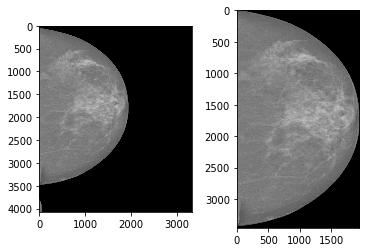

In [10]:
image = plt.imread('sample data//unprocessed_mammo//00000001.png')*255
image = np.uint8(image)
x,y,w,h = Otsu_thresholding(image) 
cropped_image = image[y:y+h,x:x+w]
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image, cmap='gray')
axarr[1].imshow(cropped_image, cmap='gray')

Preparation of the INbreast dataset, all the processed mammograms are saved in the target_folder. The bounding boxes coordinates in ".tsv" file are available here (https://github.com/riblidezso/frcnn_cad from Ribli, Dezs?, et al. "Detecting and classifying lesions in mammograms with Deep Learning." Scientific Reports 8.1 (2018): 4165.

This step may take some time but is only necessary once. We can directly observe that we are facing a huge class imbalance (fortunately, begnin cases are much more common than malignant cases). It will be important to keep this fact in mind for **chapter 2**.

We will now have processed mammograms (cropped as much as possible to reduce the number of dark pixels and oriented from left to right as the example above) in the folder "mammo" and the corresponding mask in the folder "mask" (croppend and with the same orientation of course).

In [10]:
def read_INbreast(path_boxes,inbreast_folder,target_folder,image_format=".png"):
    """
    Prepare the INbreast dataset, save the processed mammograms (otsu thresholding + crop + new format(img_format))
    in target folder and a csv file containing a description of each saved image 
    ('image id' : a new image id (from 0 to 409), 'file id' : old file name,'Birads' : BI-Rads classification, 
    'x0','x1','y0','y1' : the bounding box coordinates (if there is a tumour)
    input: 
    path_boxes (str) : path to .tsv file containing the bounding boxes coordinates of the tumors
    inbreast_folder (str) : path to the folder containing the INbreast data
    target_folder (str): folder in which to save the processed mammograms and the description csv file 
    image_format (str) : saving format
    """
    
    #create target folder if it does not exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    if not os.path.exists(os.path.join(target_folder,'mammo')):
        os.makedirs(os.path.join(target_folder,'mammo'))
        
    file = open(path_boxes) 
    read_file = csv.reader(file, delimiter="\t")
    d = {}
    first = True
    for line in read_file:
        if not first:
            file_id = line[0].split('_')[0]
            d[file_id] = line[1:5]
        else:
            first = False
    data_folder = os.path.join(inbreast_folder,"AllDICOMs")
    df = pd.read_csv(os.path.join(inbreast_folder,"INbreast.csv"),delimiter=";")
    l = []
    image_id = 0
    for file in os.listdir(data_folder):
        if ".dcm" in file:
            file_id = file.split("_")[0]
            if image_id %100==0:
                print("image number :",image_id)
            output_file = "{:08d}{}".format(image_id, image_format)
            with pydicom.dcmread(os.path.join(data_folder, file)) as dcm_file:
                raw_image = dcm_file.pixel_array
                old_h,old_w = raw_image.shape
                image = cv.normalize(raw_image, None, 0, 255, norm_type=cv.NORM_MINMAX) # LOSE INFORMATION
                image = np.uint8(image)
                flip = False
                if df.loc[df["File Name"] == int(file_id)]["Laterality"].values[0]=="R":
                    image = cv.flip(image, 1)
                    flip = True # Need to change the coordinates of the box (if positive case)
    
                x,y,w,h = Otsu_thresholding(image) 
                image = image[y:y+h,x:x+w]
            
                # Flip horizontally if laterality == "R"
            cv.imwrite(os.path.join(target_folder,"mammo", output_file), image)  # save image

            if file_id in d:
                if not flip:
                    x0 = str(max(0,int(d[file_id][0])-x))  # because we cropped the image
                    x1 = str(int(d[file_id][1])-x)
                    y0 = str(int(d[file_id][2])-y) # because we cropped the image
                    y1 = str(int(d[file_id][3])-y) 
                    l.append([image_id,file_id,df.loc[df["File Name"] == int(file_id)]["Bi-Rads"].values[0],w,h,x0,x1,y0,y1])
                else:
                    # coordinates are in the order : x0,x1,y0,y1 -- flip (w.r.t vertical axis) --> new_x0 = w - x1, new_x1 = w - x0
                    x0 = str(max(0,old_w - (int(d[file_id][1])-x))) # because we cropped the image then flipped the image
                    x1 = str(old_w - (int(d[file_id][0])-x))
                    y0 = str(int(d[file_id][2])-y)
                    y1 = str(int(d[file_id][3])-y)
                    l.append([image_id,file_id,df.loc[df["File Name"] == int(file_id)]["Bi-Rads"].values[0],w,h,x0,x1,y0,y1])
            else:
                l.append([image_id,file_id,df.loc[df["File Name"] == int(file_id)]["Bi-Rads"].values[0],w,h,'none','none','none','none'])
        image_id +=1
        
    desc = pd.DataFrame(l, columns=['image id', 'file id','Birads','width','height','x0','x1','y0','y1'])
    desc.to_csv(os.path.join(target_folder,'description.csv'))
    print('done !')
    

In [7]:
# Replace by your own paths
path_boxes = "Detection_boxes\\frcnn_cad-master\\data\\inbreast_ground_truth_cancer_bbox_rois.tsv"
inbreast_folder = "Dataset" # path to the downloaded folder (see chapter 1)
target_folder = "processed_inbreast" # the folder where the processed mammograms and .csv file are saved 

In [76]:
read_INbreast(path_boxes,inbreast_folder,target_folder,image_format=".png")

image number : 0
image number : 100
image number : 200
image number : 300
image number : 400
done !


#### Step 4 : Create the patches
For some applications, it will be easier to use patches of the mammogram instead of the all image. We create patches of size 224x224 and save the % of pixels of the patch inside the bounding box (containing the tumor if there is one). We must keep in mind that some tumors are quite small but other are much larger than those patches.
In order not to use too much memory, it was preferred to store only the file name of the whole mammogram and the patch coordinates in a csv file (instead of creating one image per patch). This will be handled in **step 1 chapter 2**.
We keep only patches with more than 40% of the pixels inside the bounding box and discard the patches with a ratio between 1% and 40% (to prevent our models from learning to classify as benign, patches that still have some malignant characteristics).

In [8]:
def prepare_data_INbreast_stride(data_folder,target_folder = "processed_tiles",tiles_format = ".png",stride = (56,56),height=224,width=224):
    """
    Prepare the INbreast dataset, save a description csv file "description_pos.csv" with the positive patches and "description_neg.csv" 
    with the negative patches
    ('num_patch' : a number associated to each patch, 'image_id' : the corresponding image (from 0 to 409), 'X' and 'Y' : the top left coordinates
    of the patch, 'width' and 'height' : the size of the patch, 'tumor ratio' : the % of pixels inside the bounding box
    input: 
    data_folder (str) : path to the folder containing the INbreast data
    target_folder (str) : folder in which to save the description csv files
    tiles_format (str) : saving format
    stride (tuple) : stride to create the patches
    height (int) : height of the patches
    width (int) : width of the patches
    """
    
    df = pd.read_csv(os.path.join(data_folder,"description.csv"))
    #desc = pd.read_csv(os.path.join(path,"Data","INbreast.csv"),delimiter=";")
    #numpy_folder = "processed_tiles_normalized"
    if not os.path.exists(os.path.join(data_folder)):
        print("No folder with data")
        return None
    
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
        
    l_pos = []
    l_neg = []
    num_crop = 0
    for f in range(len(df)):
        image_id = "{:08d}".format(f)
        X0 = df.loc[df["image id"] == int(image_id)]["x0"].values[0]
        X1 = df.loc[df["image id"] == int(image_id)]["x1"].values[0]
        Y0 = df.loc[df["image id"] == int(image_id)]["y0"].values[0]
        Y1 = df.loc[df["image id"] == int(image_id)]["y1"].values[0]
        w = df.loc[df["image id"] == int(image_id)]["width"].values[0]
        h = df.loc[df["image id"] == int(image_id)]["height"].values[0]
        filename = df.loc[df["image id"] == int(image_id)]["file id"].values[0]
        cancer = False
        if X0!="none" and X1!="none" and Y0!="none" and Y1!="none":
            cancer = True
            X0 = int(X0)
            X1 = int(X1)
            Y0 = int(Y0)
            Y1 = int(Y1)
            area_bounding_box = (X1-X0)*(Y1-Y0)
        else:
            area_bounding_box = 0
        
        n_tiles_height = (h-height)//stride[0]
        n_tiles_width = (w-width)//stride[1]
        n_tiles =  n_tiles_height*n_tiles_width
        Y_start = (h - height-n_tiles_height*stride[0])//2
        X_start = (w - width-n_tiles_width*stride[1])//2
        c = 0
        Y = Y_start
        thresh = height*width//2 # more than half of the pixels are not dark
        for i in range(n_tiles_height):
            X = X_start
            for j in range(n_tiles_width):
                tile = image[Y:Y+height,X:X+width]
                if np.sum(tile <= 1)< thresh:
                    c += 1
                    if cancer:
                        Y0_tumor = max(Y,Y0)
                        X0_tumor = max(X,X0)
                        Y1_tumor = min(Y+height,Y1)
                        X1_tumor = min(X+width,X1)
                        tumor = 0
                        area_tumor_tile = 0
                        if X0_tumor>= X1 or X1_tumor <= X0 or Y1_tumor<=Y0 or Y0_tumor >= Y1:
                            tumor = 0.0
                        else:
                            area_tumor_tile = (X1_tumor-X0_tumor)*(Y1_tumor-Y0_tumor)
                            tumor = area_tumor_tile/(height*width)
                    else:
                        tumor = 0.0
                
                    if tumor>0.4:
                        l_pos.append([num_crop,image_id,X,Y,width,height,tumor])
                        num_crop += 1
                    elif tumor<0.01:
                        l_neg.append([num_crop,image_id,X,Y,width,height,tumor])
                        num_crop += 1
                X += stride[1]
            Y += stride[0]
        if int(image_id) %100==0:
            print("image number :",int(image_id))
    desc_pos = pd.DataFrame(l_pos,columns=['num_patch','image_id','X','Y','width','height','tumor ratio'])
    desc_pos.to_csv(os.path.join(target_folder,'description_pos.csv'),index=False)
        
    desc_neg = pd.DataFrame(l_neg,columns=['num_patch','image_id','X','Y','width','height','tumor ratio'])
    desc_neg.to_csv(os.path.join(target_folder,'description_neg.csv'),index=False)
    print('done !')

In [9]:
data_folder = "processed_inbreast" # the folder where the processed mammograms and .csv file are saved, normally the same as in the previous step

In [95]:
prepare_data_INbreast_stride(data_folder,target_folder = "processed_tiles")

image number : 0
image number : 100
image number : 200
image number : 300
image number : 400
done !


#### Summary chapter 1
We have downloaded, analysed and preprocessed the INbreast dataset. We can access mammograms with a maximum of pixels containing information but also patches of size 224x224 that will allow us to localise tumours in the next chapter.

# Chapter 2 : Localisation
In this chapter, we will train models able to detect a tumour in mammograms. We will focus on traditionnal machine learning techniques fed by several features inspired by the analyse done in **step 2** of **chapter 1**.

The main steps of this chapter are summarised below: 
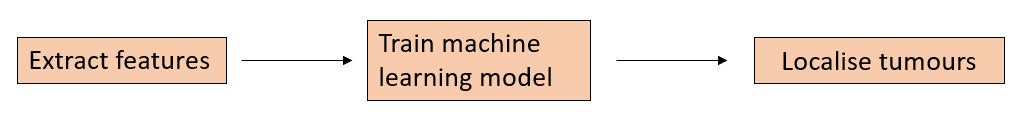

In [33]:
# additional import
import torch
from pydicom import dcmread
import random
import pywt
import mahotas
from skimage.feature import hog
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
import matplotlib.image as mpimg
import tqdm
import math
from PIL import Image,ImageOps

In [7]:
random.seed(10) # for reproducibility

#### Step 1 : Preparation of the dataset
To train machine learning models, we will need a dataset of patches and split it into training, validation and test set. If you did not download the dataset, you can **skip** this part (see **end skip**).

In [18]:
class INbreastDataset(torch.utils.data.Dataset):
    def __init__(self,data_folder,csv_dir,pos=True,img_format='.png'):
        self.data_folder = data_folder
        if pos:
            self.desc = pd.read_csv(os.path.join(csv_dir,'description_pos.csv'))
        else:
            self.desc = pd.read_csv(os.path.join(csv_dir,'description_neg.csv'))                  
        self.pos = pos
        self.img_format = img_format
        
    def __len__(self):
        return len(self.desc)
    
    def __getitem__(self, idx):

        X = self.desc['X'][idx]
        Y = self.desc['Y'][idx]
        w = self.desc['width'][idx]
        h = self.desc['height'][idx]
        image_id = "{:08d}".format(self.desc['image_id'][idx])
        img = mpimg.imread(os.path.join(self.data_folder,'mammo',image_id+self.img_format))
        
        data =  img[Y:Y+h,X:X+w]*255
        if self.pos:
            target = 1
        else:
            target = 0
        return data,target

In [19]:
data_folder = "processed_inbreast" # the folder where the processed mammograms and .csv file are saved, normally the same as in the previous step
csv_dir = 'processed_tiles' # the folder where the .csv files from step 4 are saved

In [20]:
dataset_pos = INbreastDataset(data_folder,csv_dir,pos=True)
dataset_neg = INbreastDataset(data_folder,csv_dir,pos=False)

We choose to select all positive cases and twice as many negative cases (so that we do not have to tackle a too huge class imbalance during training).

In [21]:
n_pos = len(dataset_pos)
n_neg = n_pos*2
print('number of positive cases:',n_pos)
print('number of negative cases:',n_neg)

number of positive cases: 4815
number of negative cases: 9630


Then we divide our dataset in training, validation and test set. We will use 80% of the data for training, 10% for validation and 10% for testing.

In [22]:
length = n_pos + n_neg

n_train = int(length*0.8)
n_val = int(length*0.1)
n_test = length-n_train-n_val
print('number of patches for training:',n_train,'for validation:',n_val,'for testing:',n_test)

neg_indices = [i for i in range(n_neg)]
random.shuffle(neg_indices)
final_dataset_neg = torch.utils.data.Subset(dataset_neg, neg_indices)
dataset = torch.utils.data.ConcatDataset([final_dataset_neg,dataset_pos])

indices = [i for i in range(length)]
random.shuffle(indices)
train_ind = indices[0:n_train]
test_ind = indices[n_train:n_train+n_test]
val_ind = indices[n_train+n_test:n_train+n_test+n_val]

number of patches for training: 11556 for validation: 1444 for testing: 1445


**end skip**

#### Step 2 : feature extraction
The feature extraction is inspired by the paper : S. B. Yengec Tasdemir, K. Tasdemir and Z. Aydin, "ROI Detection in Mammogram Images Using Wavelet-Based Haralick and HOG Features," 2018 17th IEEE International Conference on Machine Learning and Applications (ICMLA), 2018, pp. 105-109, doi: 10.1109/ICMLA.2018.00023.

The big idea is to process a 2D Wavelet decomposition of the region of interest and use all of the four sub-images to extract the Haralick features but only using the approximation image to extract the HOG features.

In [35]:
n_features_hog = 392
n_features_har = 208
n_features_gab = 360
n_features = n_features_hog + n_features_har + n_features_gab # 960 features

Wavelet Transform : we use PyWavelets library of Python as proposed in the paper.

In [34]:
def wavelet(crop,plot=True):
    """
    Wavelet transform of image, and plot approximation and details
    """
    if plot:
        plt.imshow(crop, cmap="gray")
    titles = ['Approximation', ' Horizontal detail',
              'Vertical detail', 'Diagonal detail']
    coeffs2 = pywt.dwt2(crop, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    LL = LL + abs(min(0,np.amin(LL)))
    LH = LH + abs(min(0,np.amin(LH)))
    HL = HL + abs(min(0,np.amin(HL)))
    HH = HH + abs(min(0,np.amin(HH)))
    if plot:
        fig = plt.figure(figsize=(12, 3))
        for i, a in enumerate([LL, LH, HL, HH]):
            ax = fig.add_subplot(1, 4, i + 1)
            ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
            ax.set_title(titles[i], fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
        fig.tight_layout()
        plt.show()
    return LL,LH,HL,HH

Example of wavelet transform on a positive patch

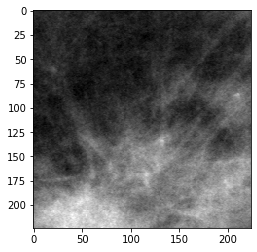

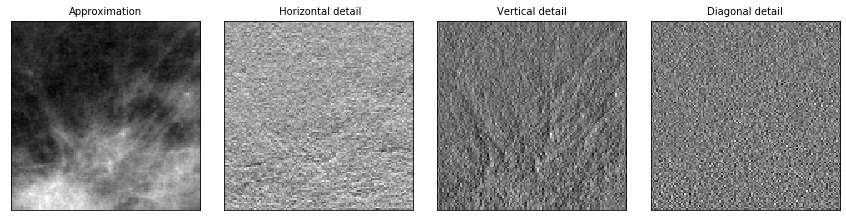

In [36]:
patch = mpimg.imread(os.path.join('sample data','patch','patch_3.png')) # load a patch as an example
LL,LH,HL,HH = wavelet(patch,True) # Approximation and details of the Wavelet Transform

The main idea of histograms of oriented gradients (hog) is to compute histograms of orientation of gradients of an image divided into a grid. They became famous especially after this publication : *N. Dalal and B. Triggs, "Histograms of oriented gradients for human detection," 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05), 2005, pp. 886-893 vol. 1, doi: 10.1109/CVPR.2005.177.*

Since a malignant mass is characterized mainly by its shape and contour, hog feature seems a good candidate to discriminate begnin and malignant cases.

In [32]:
def HOG(crop):
    """
    Histogram of oriented gradients
    """
    fd, hog_image = hog(crop, orientations=8,pixels_per_cell = (16,16),cells_per_block=(1, 1),visualize=True, multichannel=False)
    return fd,hog_image

Example with visualisation:

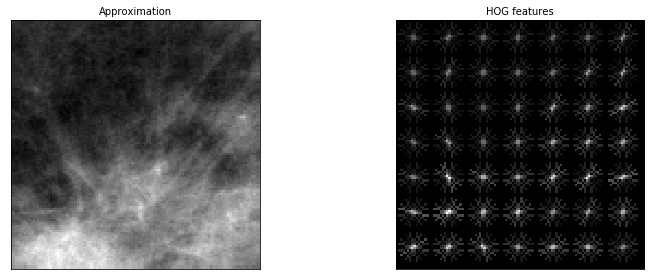

In [33]:
fd,hog_image = HOG(LL) # fd are the hog features and hog_image is an image allowing a visualization of the directions of the gradients

# Plot
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(LL, interpolation="nearest", cmap=plt.cm.gray)
ax.set_title('Approximation', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(hog_image, interpolation="nearest", cmap=plt.cm.gray)
ax.set_title('HOG features', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
plt.show()

The second type of features we will extract from our patches is Haralick features. Haralick features are texture features and are the summary of several characteristics of the pixels of an image (mean, variance, correlation, ...). Their use makes sense since a mass will have a different density and texture than other breast tissues. Some of these features are listed below:
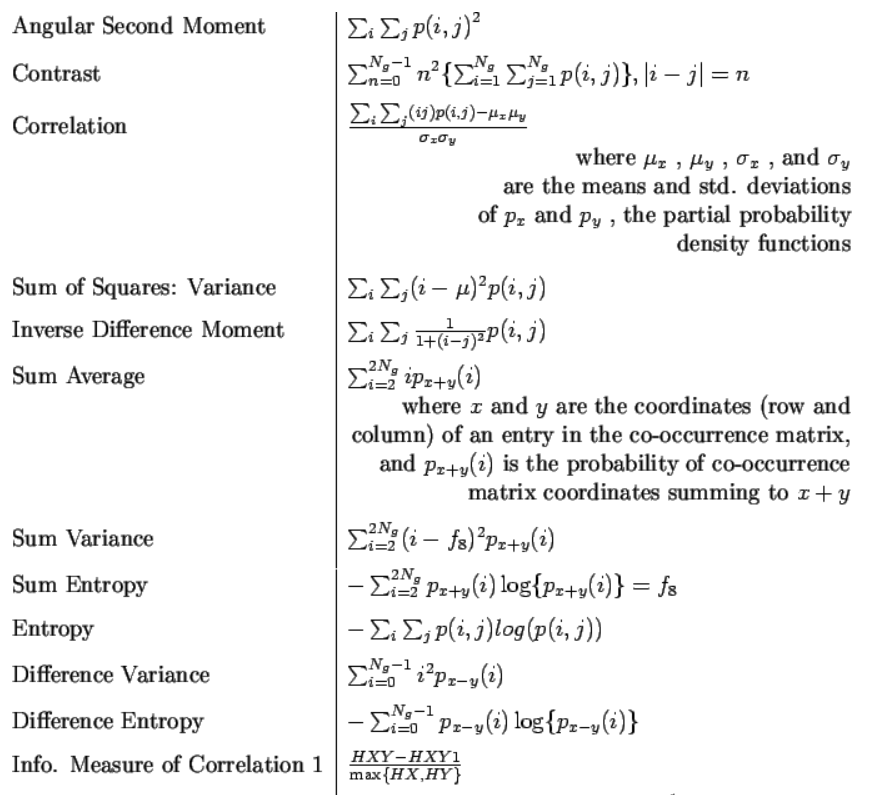 (Source : http://murphylab.web.cmu.edu/publications/boland/boland_node26.html)

In [34]:
def Haralick(LL,LH,HL,HH):
    """
    Haralick features of Wavelet approximations and details
    """
    haralick_LL = mahotas.features.haralick(LL.astype(int)).reshape(-1,1)
    haralick_LH = mahotas.features.haralick(LH.astype(int)).reshape(-1,1)
    haralick_HL = mahotas.features.haralick(HL.astype(int)).reshape(-1,1)
    haralick_HH = mahotas.features.haralick(HH.astype(int)).reshape(-1,1)
    haralick = np.array([haralick_LL,haralick_LH,haralick_HL,haralick_HH])
    haralick = haralick.reshape((-1,))
    return haralick

The third features are Gabor filters. They are linear filter used for texture analysis. It analyzes mainly whether there is any specific frequency content in the image in specific directions.

In [1]:
def gabor(crop, kernels):
    """
    Apply gabor filters (kernels) to the image crop
    Compute the mean, variance and difference between the highest and lowest pixel
    """
    feats = np.zeros((len(kernels)*3,), dtype=np.double)
    count = 0
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(crop, kernel, mode='wrap')
        feats[count] = filtered.mean()
        feats[count+1] = filtered.var()
        feats[count+2] = filtered.max()-filtered.min()
        count += 3
    return feats

Example of a gabor filter applied to the previous patch.

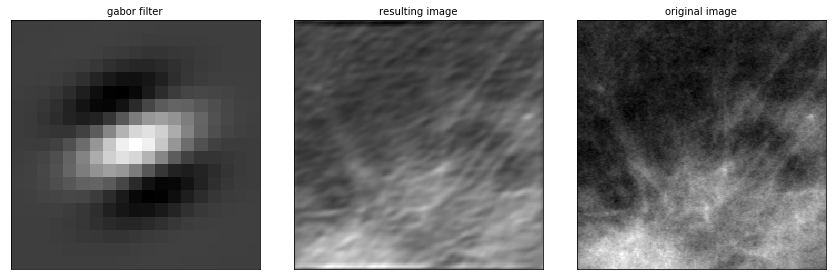

In [36]:
kernel = np.real(gabor_kernel(frequency=0.1, theta= 3 / 8 * np.pi,sigma_x=3, sigma_y=3)) # a gabor filter
filtered = ndi.convolve(patch, kernel, mode='wrap') # apply convolution

# Plot
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(kernel, interpolation="nearest", cmap=plt.cm.gray)
ax.set_title('gabor filter', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(1, 3, 2)
ax.imshow(filtered, interpolation="nearest", cmap=plt.cm.gray)
ax.set_title('resulting image', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
ax = fig.add_subplot(1, 3, 3)
ax.imshow(patch, interpolation="nearest", cmap=plt.cm.gray)
ax.set_title('original image', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
plt.show()

In [37]:
# We prepare the gabor filters (to compute them only once)
kernels = []
# gabor filters
max_theta = 8
for theta in range(max_theta):
    theta = theta / float(max_theta) * np.pi
    for sigma in (0.5,1,3):
        for frequency in (0.05, 0.1, 0.25, 0.5,1):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

By putting all together, we concatenate all the features to create a vector. We are now ready to train machine learning models and observe which feature has the most impact.

In [32]:
def extract_features(crop,kernels,plot=True):
    """
    Extract features (HOG + Wavelet approximation, Haralick + Wavelet approximation and details, gabor)
    """
    LL,LH,HL,HH = wavelet(crop,plot=plot)
    hog,_ = HOG(LL)
    haralick = Haralick(LL,LH,HL,HH)
    gabor_features = gabor(crop, kernels)
    features = np.concatenate((hog,haralick,gabor_features))
    return features

We prepare the feature matrix of the training set : this step may take some time. You can **skip** this part and only load the precomputed features (see **end skip**)

In [171]:
features_train = np.zeros((n_train,n_features),dtype=np.float32)
Y_train = np.zeros((n_train,))

for  k,i in tqdm.tqdm(enumerate(train_ind)):
    image = dataset[i][0]
    f = extract_features(image,kernels,plot=False)
    features_train[k,:] = f
    Y_train[k] = dataset[i][1]

11556it [5:57:30,  1.86s/it]


We save our features and labels.

In [174]:
features_folder = "features"
if not os.path.exists(features_folder):
    os.makedirs(features_folder)
np.save(os.path.join(features_folder,"features_train_2.npy"),features_train)
np.save(os.path.join(features_folder,"y_train_2.npy"),Y_train)

**End skip** we can just load the precomputed features saved in the folder "features" as well as the labels.
If you want 2 times more features from negatives patches, use "features_train_2.npy" and "y_train_2.npy". If you want a class balance (as many negative cases than positive cases) use "features_train.npy" and "y_train.npy" below.

In [11]:
features_folder = "features"
features_train = np.load(os.path.join(features_folder,"features_train_2.npy"))
Y_train = np.load(os.path.join(features_folder,"y_train_2.npy"))

We do the same thing for the validation set : this step will take less time. Again we can also load the precomputed features.

In [172]:
features_val = np.zeros((n_val,n_features),dtype=np.float32)
Y_val = np.zeros((n_val,))

for k,i in tqdm.tqdm(enumerate(val_ind)):
    image = dataset[i][0]
    f = extract_features(image,kernels,plot=False)
    features_val[k,:] = f
    Y_val[k] = dataset[i][1]

1444it [45:46,  1.90s/it]


We save our features and labels.

In [175]:
features_folder = "features"
if not os.path.exists(features_folder):
    os.makedirs(features_folder)
np.save(os.path.join(features_folder,"features_val_2.npy"),features_val)
np.save(os.path.join(features_folder,"y_val_2.npy"),Y_val)

**End skip** we can just load the precomputed features saved in the folder "features" as well as the labels.

In [12]:
features_folder = "features"
features_val = np.load(os.path.join(features_folder,"features_val_2.npy"))
Y_val = np.load(os.path.join(features_folder,"y_val_2.npy"))

A last thing we need to do is normalise our features, which has been proven to improve the overall performance of machine learning models (for example, read https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0)

In [13]:
means = np.mean(features_train,axis=0)
stds = np.std(features_train,axis=0)

In [14]:
features_train = (features_train - means.reshape(1,-1))/stds.reshape(1,-1)

In [15]:
features_val = (features_val - means.reshape(1,-1))/stds.reshape(1,-1)

#### Step 3 : patch classification models
We will train several machine learning models and observe which one is the most appropriate for this task.

In [16]:
best_clf = None # to keep the best classifier
best_score = -1 # save its score

We begin with a simple regression as a baseline.

In [17]:
clf = LinearRegression()
clf.fit(features_train, Y_train)
score = clf.score(features_val,Y_val)
best_score = score
best_clf = clf
print('baseline score:', score)

baseline score: 0.6909304641760641


If you do not want to train several models, you can just use the following lines (according to our experiments, this model works quite well for several configurations), otherwise skip the next cell.

In [67]:
best_clf = AdaBoostClassifier(n_estimators=600, random_state=0)
best_clf.fit(features_train, Y_train)
score = best_clf.score(features_val,Y_val)
print('score:',score)

score: 0.9660664819944599


We try to improve this score with an AdaBoost classifier (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [181]:
best_est = 0
for n_est in [200,400,600]:
    clf = AdaBoostClassifier(n_estimators=n_est)
    clf.fit(features_train, Y_train)
    score = clf.score(features_val,Y_val)
    print('n_estimators:',n_est,'score:',score)
    if score>best_score:
        best_clf = clf
        best_score = score
        best_est = n_est
print("best score is ",best_score," with n_estimators =",best_est)

n_estimators: 200 score: 0.9501385041551247
n_estimators: 400 score: 0.9591412742382271
n_estimators: 600 score: 0.9660664819944599
best score is  0.9660664819944599  with n_estimators = 600


We can already look at the most used features. Reminder : the first 392 features are HOG ones, the next 208 featuers haralick ones and then we have 360 gabor features.
* \[0,391\] : HOG 
* \[392,599\] : haralick
* \[600:899\] : gabor features

We observe that the three kinds of features are used, further analysis will be carried out later on. 

In [2]:
select = best_clf.feature_importances_
plt.bar([i for i in range(n_features)],select)
plt.savefig('feature_selection.png')
plt.show()

NameError: name 'best_clf' is not defined

Then we train a Support Vector Machine classifier (https://scikit-learn.org/stable/modules/svm.html)

In [183]:
best_kernel = None
for k in ['rbf','poly','sigmoid']:
    clf = svm.SVC(kernel=k)
    clf.fit(features_train, Y_train)
    score = clf.score(features_val,Y_val)
    print('kernel:',k,'score:',score)
    if score > best_score:
        best_score = score
        best_clf = clf
        best_kernel = k

kernel: rbf score: 0.9397506925207756
kernel: poly score: 0.8677285318559557
kernel: sigmoid score: 0.7160664819944599


The most promising classifier according to our experiments is a Random Forest classifier (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [27]:
best_estim_for = 0
best_score=0
best_depth = 0
for criterion in ["entropy"]: # experiments show that entropy gives better performance in general than gini
    for n_est in [200,350,500,650,900]:
        for depth in [25,None]:
            clf = RandomForestClassifier(n_estimators=n_est,max_depth=depth,criterion=criterion)
            clf.fit(features_train, Y_train)
            score = clf.score(features_val,Y_val)

            if score>best_score:
                best_score = score
                best_clf = clf
                best_estim_for = n_est
                best_depth = depth
                print('best model until now :','criterion:',criterion,'n_estimators:',n_est,'depth:',depth,'score:',score)

best model until now : criterion: entropy n_estimators: 200 depth: 25 score: 0.9757617728531855


KeyboardInterrupt: 

Finally, we compare them with several other classifiers.
* Gaussian Naive Bayes : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
* Quadratic Discriminant Analysis : https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html
* Decision Tree classifier : https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* K-nearest Neighbors : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [46]:
clf = GaussianNB()
clf.fit(features_train, Y_train)
score = clf.score(features_val,Y_val)
if score>best_score:
    best_clf = clf
    best_score = score
print('score:',score)

score: 0.5512465373961218


In [47]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(features_train, Y_train)
score = clf.score(features_val,Y_val)
if score>best_score:
    best_clf = clf
    best_score = score
print('score:',score)

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


score: 0.7596952908587258


In [48]:
clf = DecisionTreeClassifier(max_depth=30)
clf.fit(features_train, Y_train)
score = clf.score(features_val,Y_val)
if score>best_score:
    best_clf = clf
    best_score = score
print('score:',score)

score: 0.9286703601108033


In [22]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(features_train, Y_train)
score = clf.score(features_val,Y_val)
if score>best_score:
    best_clf = clf
    best_score = score
print('score:',score)

score: 0.9362880886426593


We try a neural network (MLP : https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). The performances are worse than some previous classifiers, probably because it needs more carefully hyperparameters tuning and more data to learn better features.

In [390]:
for lr in [0.0001,0.001,0.01]:
    for alpha in [0.0001,0.001,0.01]:
        clf = MLPClassifier(learning_rate_init = lr,alpha=alpha,max_iter=500)
        clf.fit(features_train, Y_train)
        score = clf.score(features_val,Y_val)
        print('score:',score,'n_layers :',n_layers, 'lr :',lr)
        if score>best_score:
            best_clf = clf
            best_score = score

score: 0.9598337950138505 n_layers : 100 lr : 0.0001
score: 0.9646814404432132 n_layers : 100 lr : 0.0001
score: 0.9626038781163435 n_layers : 100 lr : 0.0001
score: 0.96398891966759 n_layers : 100 lr : 0.0001
score: 0.9605263157894737 n_layers : 100 lr : 0.001
score: 0.961218836565097 n_layers : 100 lr : 0.001
score: 0.9605263157894737 n_layers : 100 lr : 0.001
score: 0.9660664819944599 n_layers : 100 lr : 0.001
score: 0.9632963988919667 n_layers : 100 lr : 0.01
score: 0.9577562326869806 n_layers : 100 lr : 0.01
score: 0.9556786703601108 n_layers : 100 lr : 0.01
score: 0.9515235457063712 n_layers : 100 lr : 0.01


In [23]:
print(best_clf)

KNeighborsClassifier()


Before going to **step 4**, we need to assess the performance of our best model (best_clf) on the test set. Again we can **skip** this and just load the already computed features.

In [393]:
features_test = np.zeros((n_test,n_features))
Y_test = np.zeros((n_test,))
for k,i in tqdm.tqdm(enumerate(test_ind)):
    image = dataset[i][0]
    f = extract_features(image,kernels,plot=False)
    features_test[k,:] = f
    Y_test[k] = dataset[i][1]

1445it [34:25,  1.43s/it]


We save our features and labels.

In [394]:
features_folder = "features"
if not os.path.exists(features_folder):
    os.makedirs(features_folder)
np.save(os.path.join(features_folder,"features_test_2.npy"),features_test)
np.save(os.path.join(features_folder,"y_test_2.npy"),Y_test)

**End skip** to load the features and labels.

In [24]:
features_folder = "features"
features_test = np.load(os.path.join(features_folder,'features_test_2.npy'))
Y_test = np.load(os.path.join(features_folder,'y_test_2.npy'))

Of course, we need to do the same processing (normalisation).

In [25]:
features_test = (features_test - means.reshape(1,-1))/stds.reshape(1,-1)

In [28]:
print('score of best classifier:',best_clf.score(features_test, Y_test))
Y_pred = best_clf.predict(features_test)
TP = 0
FP = 0
TN = 0
FN = 0
for i in range(features_test.shape[0]):
    if Y_pred[i]==Y_test[i]:
        if Y_pred[i]==1:
            TP += 1
        else:
            TN +=1
    else:
        if Y_pred[i]==1:
            FP+= 1
        else:
            FN+=1
       
accuracy = TP/(TP+FP)
print("accuracy:",accuracy)
recall = TP/(TP+FN)
print("recall:",recall)

score of best classifier: 0.9688581314878892
accuracy: 0.9573560767590619
recall: 0.9472573839662447


#### Step 4 : Localisation
Now we want to localise a tumour by looking at the whole mammogram.
The idea is to go through a mammogram like a sliding window and classify each patch into benign (0) or malignant (1) and then combine all these predictions to produce a heatmap.

In [29]:
stride = 56 # stride of sliding window
l = 224 # size of each patch (lxl)

In [30]:
def sliding_window(image,mean,std,stride=32):
    h,w = image.shape
    heatmap = np.zeros((h,w))
    i=0
    j=0
    n_steps = (h-l)//stride # for the progress bar
    with tqdm.tqdm(total=n_steps) as pbar:
        while l+i*stride<h:
            while l+j*stride<w:
                crop = image[i*stride:l+i*stride,j*stride:l+j*stride]
                f = extract_features(crop,kernels,False).reshape(1,-1)
                f = (f - mean.reshape(1,-1))/std
                heatmap[i*stride:l+i*stride,j*stride:l+j*stride]+=best_clf.predict(f)*np.ones((l,l))
                j = j + 1
            j=0
            i=i+1
            pbar.update(1)
    return heatmap

We test our methods on mammograms present in the sample folder. It is important to note that even if some mammograms are negative (no tumour), they have a mask presenting some abnormalities (e.g. a begnin mass).

In [31]:
sample1 = os.path.join('sample data','mammo','00000001.png')
mask1 = mpimg.imread(os.path.join('sample data','mask','00000001.png'))
image1 = mpimg.imread(sample1)*255
heatmap1 = sliding_window(image1,means,stds,stride)
np.save('results/heatmap1.npy',heatmap1)

  0%|          | 0/57 [00:00<?, ?it/s]


NameError: name 'extract_features' is not defined

In [ ]:
sample2 = os.path.join('sample data','mammo','00000002.png')
mask2 = mpimg.imread(os.path.join('sample data','mask','00000002.png'))
image2 = mpimg.imread(sample2)*255
heatmap2 = sliding_window(image2,means,stds,stride)
np.save('heatmap2.npy',heatmap2)

NameError: name 'heatmap1' is not defined

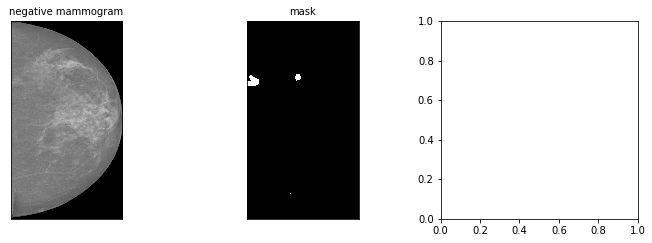

In [77]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2, 3, 1)
ax.imshow(image1, cmap=plt.cm.gray)
ax.set_title('negative mammogram', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(2, 3, 2)
ax.imshow(mask1, cmap=plt.cm.gray)
ax.set_title('mask', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(2, 3, 3)
ax.imshow(heatmap1)
ax.set_title('resulting heatmap', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
ax = fig.add_subplot(2, 3, 4)
ax.imshow(image2, cmap=plt.cm.gray)
ax.set_title('positive mammogram', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(2, 3, 5)
ax.imshow(mask2, cmap=plt.cm.gray)
ax.set_title('mask', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(2, 3, 6)
ax.imshow(heatmap2)
ax.set_title('resulting heatmap', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
plt.show()

Just a few lines of code to overlay the heatmap and the corresponding mammogram...

In [143]:
from matplotlib import cm
def transparent_1(heatmap): 
    img = Image.fromarray(np.uint8((heatmap/np.max(heatmap))*255))
    #img_gray = ImageOps.grayscale(img)
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        if item[0]==68 and item[1]==1 and item[2]==84:
            newData.append((0, 0, 0, 0))
        else:
            if item[0]==72 and item[1]==28 and item[2]==110:
                newData.append((item[0],item[1],item[2],20))
            else:
                newData.append((item[0],item[1],20,50))
 
    img.putdata(newData)
    return img
    #img.save("image_transparente.png", "PNG") # ca enregistre l'image dans le même dossier que là où est le code
    
def superposer_img(ft,bg): # ft = front , bg = background
 
    filename1 = bg
    background = Image.open(filename1, 'r')
    text_img = Image.new('RGBA', background.size , (0, 0, 0, 0))
    text_img.paste(background, (0,0))
    text_img.paste(ft, (0,0), mask=ft)
    #text_img.save("image_{}.png".format(file_id), format="png")
    text_img.show() 

Execute this to superpose the heatmap on the mammogram.

In [144]:
data_folder = 'processed_inbreast'
sample2 = os.path.join('sample data','mammo','00000002.png')
heatmap_transp = transparent_1(heatmap2)
superposer_img(ft = heatmap_transp,bg=sample2)

# Chapter 3 : Segmentation of a tumour (mass)
Now that we can localise a tumour, we want a more precise segmentation of its contours, i.e. to label each pixel as belonging or not to the tumour.

The main steps of this chapter are summarised below:
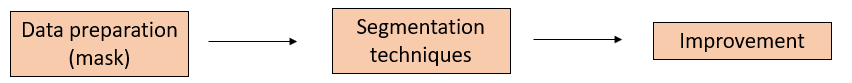

#### Step 1 : Preparation

For some techniques presented below we will need a data structure called priority queue.

In [ ]:
# A simple implementation of Priority Queue 
class PriorityQueue(object): 
    def __init__(self): 
        self.queue = [] 
  
    def __str__(self): 
        return ' '.join([str(i) for i in self.queue]) 
  
    # for checking if the queue is empty 
    def isEmpty(self): 
        return len(self.queue) == 0
  
    # for inserting an element in the queue 
    def insert(self, data): 
        self.queue.append(data) 
  
    # for popping an element based on Priority 
    def delete(self): 
        try: 
            max = 0
            for i in range(len(self.queue)): 
                if self.queue[i][0] > self.queue[max][0]: 
                    max = i 
            item = self.queue[max] 
            del self.queue[max] 
            return item 
        except IndexError: 
            print() 
            exit() 

In [ ]:
# We test our implementation
myQueue = PriorityQueue() 
myQueue.insert((12,1)) 
myQueue.insert((1,1)) 
myQueue.insert((14,1)) 
myQueue.insert((7,1)) 
print(myQueue)             
while not myQueue.isEmpty(): 
    print(myQueue.delete())

For this part we will use the sample data (folder "sample data") and its corresponding description file ("sample_description.csv" in the folder "sample data").

In [186]:
data_folder = "sample data"

In [194]:
df = pd.read_csv(os.path.join(data_folder,"sample_description.csv"))

In [193]:
print(df) # overview

   Unnamed: 0  image id   file id Birads  width  height    x0    x1    y0  \
0           0         0  20586908      2   1951    3458  none  none  none   
1           1         1  20586934      5   1651    3326    35   373  1847   
2           2         2  20586960      2   2227    3200  none  none  none   
3           3         3  20586986      5   1889    3146    51   478  2306   
4           4         4  20587054     4c   1391    2816   389   611   934   
5           5         5  20587080     4c   1502    3328   384   607  1951   
6           6         6  20587148      2    955    2533  none  none  none   

     y1  
0  none  
1  2134  
2  none  
3  2607  
4  1078  
5  2107  
6  none  


We observe our data : the 2nd, 4th, 5th and 6th mammogram shows a tumour. We observe that 2 of the regions of interest are composed of microcalcifications (for example, see https://www.mayoclinic.org/symptoms/breast-calcifications/basics/definition/sym-20050834) and the 2 others of irregular masses. We will restrict ourselves to the segmentation of the masses.

We also observe that unfortunately the segmentation are not always really precise but are a rough detour from the area of interest.

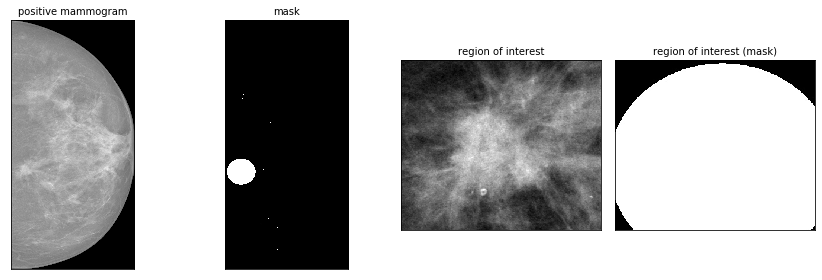

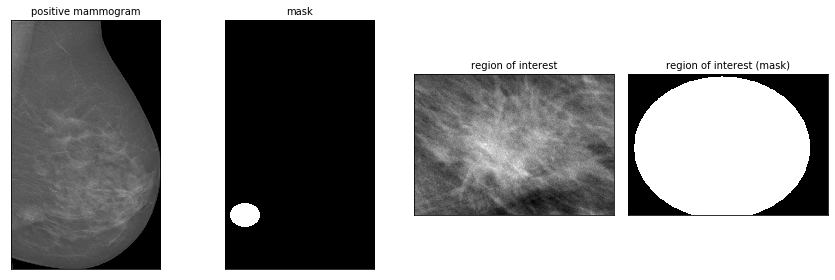

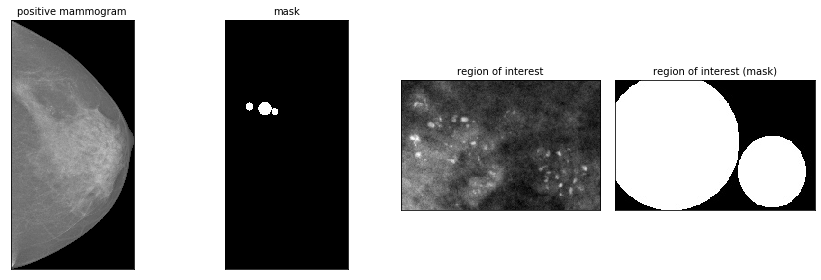

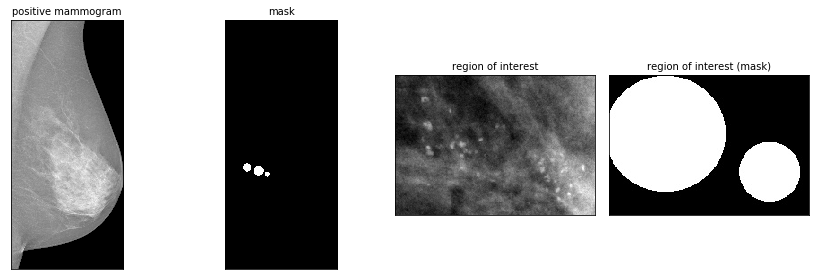

In [212]:
for i in [1,3,4,5]:
    x0 = int(df['x0'][i])
    x1 = int(df['x1'][i])
    y0 = int(df['y0'][i])
    y1 = int(df['y1'][i])

    mask = mpimg.imread(os.path.join(data_folder,'mask','{:08d}.png'.format(i+1)))
    image = mpimg.imread(os.path.join(data_folder,'mammo','{:08d}.png'.format(i+1)))
    roi = image[y0:y1,x0:x1]
    roi_mask = mask[y0:y1,x0:x1]

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 4, 1)
    ax.imshow(image, cmap=plt.cm.gray)
    ax.set_title('positive mammogram', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 4, 2)
    ax.imshow(mask, cmap=plt.cm.gray)
    ax.set_title('mask', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 4, 3)
    ax.imshow(roi,cmap='gray')
    ax.set_title('region of interest', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 4, 4)
    ax.imshow(roi_mask,cmap='gray')
    ax.set_title('region of interest (mask)', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    fig.tight_layout()
    plt.show()

We prepare our 2 regions of interest from which we take a larger contour.

In [256]:
x0s,x1s,y0s,y1s,masks,images,rois,rois_masks = [],[],[],[],[],[],[],[]
for k,i in enumerate([1,3]):
    x0s.append(max(0,int(df['x0'][i])-100))
    x1s.append(int(df['x1'][i])+100)
    y0s.append(int(df['y0'][i])-100)
    y1s.append(int(df['y1'][i])+100)
    masks.append(mpimg.imread(os.path.join(data_folder,'mask','{:08d}.png'.format(i+1)))*255)
    images.append(mpimg.imread(os.path.join(data_folder,'mammo','{:08d}.png'.format(i+1)))*255)
    rois.append(images[k][y0s[k]:y1s[k],x0s[k]:x1s[k]])
    rois_masks.append(masks[k][y0s[k]:y1s[k],x0s[k]:x1s[k]])

#### Step 2 : Segmentation techniques
We will try several segmentation techniques and observe which approach works best.

First, we will use the Otsu thresholding method presented in **chapter 1** as baseline.

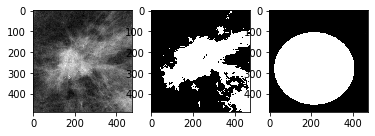

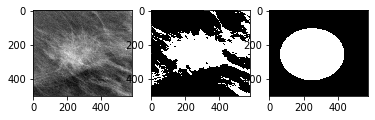

In [273]:
for i in range(2): # mammograms with a mass
    roi = rois[i]
    roi_mask = rois_masks[i]
    roi = np.uint8(roi)
    blur = cv.GaussianBlur(roi,(5,5),0)
    _, otsu_mask = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(roi, cmap='gray')
    axarr[1].imshow(otsu_mask, cmap='gray')
    axarr[2].imshow(roi_mask, cmap='gray')

We observe that this task is quite difficult. To make the task a little easier, we propose a semi-automatic technique, for which we ask the user to select one (or more) starting point(s), which we will call the seed(s).

It leeds us to another well-known segmentation technique called region growing. The idea is to start from the seeds and iteratively adds new pixels according a certain criterion.

To begin, we propose a baseline method that looks only the grayscale level of each pixel and add it to the predicted mask if the difference of grayscale level with its neighbours is lower than a threshold.

In [279]:
def region_growing(image,seeds,thresh=10):
    d = [(1,1),(0,1),(1,0),(-1,0),(1,-1),(0,-1),(-1,1),(-1,-1)]
    """
    Apply region growing, starting from the seeds.
    input :
    image is a numpy array representing a graycale image
    seed is a list of tuple representing coordinates in the image
    thresh is a threshold on the difference of pixel intensity between neighbours
    output :
    mask is a numpy array of the size of image and representing the computed segmentation mask
    """
    height, width = image.shape
    mask = np.zeros((height,width))
    m = np.mean(image)
    seedsList = []
    for seed in seeds:
        seedsList.append(seed)
    while len(seedsList) > 0:
        new_seed = seedsList.pop(0)
        mask[new_seed[0],new_seed[1]]=1
        for disp in d:
            new_y = new_seed[0]+disp[0]
            new_x = new_seed[1]+disp[1]
            if (not (0<=new_y<height and 0<=new_x<width)) or mask[new_y][new_x]==1 or image[new_y,new_x]<m:
                continue
            diff = abs(int(image[new_seed[0],new_seed[1]])-int(image[new_y,new_x]))
            if diff < thresh:
                mask[new_y,new_x]=1
                seedsList.append((new_y,new_x))
    return mask

A big unknown for this method is the threshold value (the threshold on the difference of grayscale level between neighboring pixels). But fortunalety, the technique seems to work quite well for different values of this threshold.


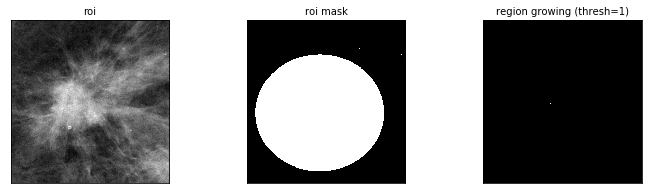

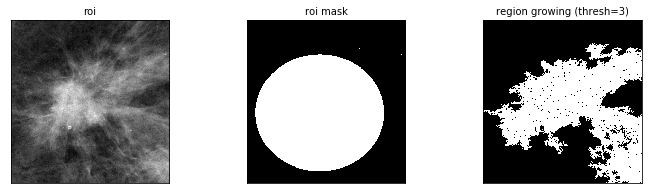

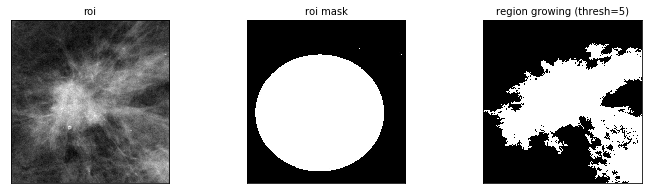

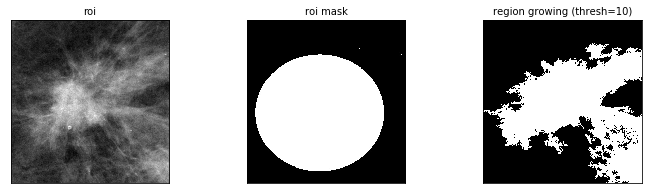

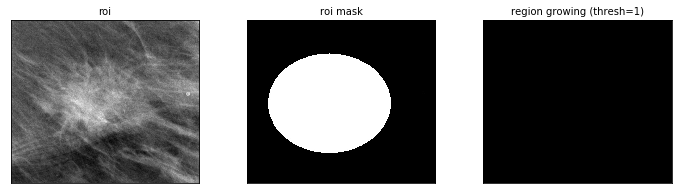

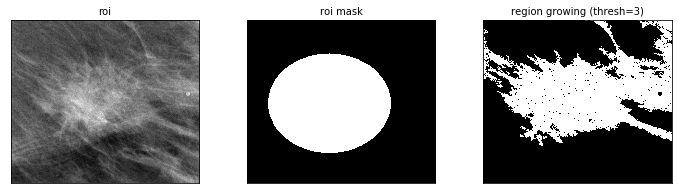

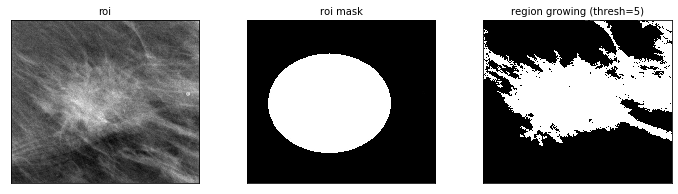

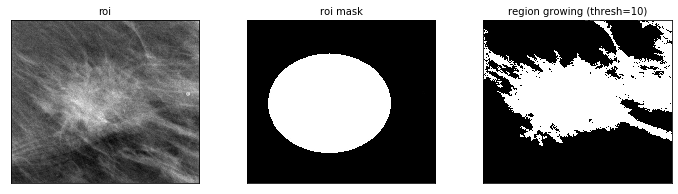

In [286]:
for i in range(2): # mammograms with a mass
    for t in [1,3,5,10]:
        roi = rois[i]
        roi_mask = rois_masks[i]
        roi = np.uint8(roi)
        new_mask = region_growing(roi,seeds=[(250,200)],thresh=t)
        titles = ['roi','roi mask','region growing (thresh='+str(t)+')']
        fig = plt.figure(figsize=(12, 3))
        for n, a in enumerate([roi,roi_mask,new_mask]):
            ax = fig.add_subplot(1, 3,n + 1)
            ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
            ax.set_title(titles[n], fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
        #fig.tight_layout()
        plt.show()

We observe that even with our eyes the outline of the mass is not clear, the image is noisy and the region growing "leaks" sometimes (bottom right for 1st roi, right and left for the second one).

First, we try to blur the region of interest. The idea is to smooth certain noisy pixels that could cause leaks.

We observe that blurring helps a bit in certain cases (there are less leaks) but do not solve our problem entirely. More precisely, we see that the leaks that do not appear anymore with blurring are leaks caused by just a few pixels attached to our interesting areas. The other leaks are much "larger" and blurring can not stop them. Therefore, we need a new stricter criterion to add pixels at each step.

In [3]:
threshold = 10
for i in range(2): # mammograms with a mass
    for size in [(5,5),(11,11),(49,49)]:
        roi = rois[i]
        blur = cv.GaussianBlur(roi,size,sigmaX=10)
        roi_mask = rois_masks[i]
        new_mask_blur = region_growing(blur,seeds=[(250,200)],thresh=threshold)
        new_mask = region_growing(roi,seeds=[(250,200)],thresh=threshold)
        titles = ['roi','blurred roi','roi mask','region growing','region growing on blurred roi (size='+str(size)+')']
        fig = plt.figure(figsize=(12, 3))
        for n, a in enumerate([roi,blur,roi_mask,new_mask,new_mask_blur]):
            ax = fig.add_subplot(1, 5,n + 1)
            ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
            ax.set_title(titles[n], fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
        #fig.tight_layout()
        plt.show()

NameError: name 'rois' is not defined

**Step 3 : improvement of the mask**

This step aims to remove small objects from the foreground. To do that, we use a mathematical morphology operator called opening (erosion followed by dilatation : https://en.wikipedia.org/wiki/Opening_(morphology)).

In [380]:
def opening(mask,kernel_size):
    kernel = np.ones(kernel_size,np.uint8)
    opening = cv.morphologyEx(new_mask,cv.MORPH_OPEN,kernel)
    return opening

#### Step 4 : improvement of the selected technique 
As we observed in **step 1, 2 and 3**, making a segmentation is not an easy task.

First, we improve the mean value. We compute it in an area around the seed point and not on the all image as above (a square of length 2*begin_step centered on the seed point).

In [329]:
def region_growing_mean(image,begin_step,seeds,thresh=10):
    d = [(1,1),(0,1),(1,0),(-1,0),(1,-1),(0,-1),(-1,1),(-1,-1)]
    """
    Apply region growing, starting from the seeds, with a mean threshold computed in a square centered on the seeds 
    and of length 2*begin_step
    input :
    image is a numpy array representing a graycale image
    begin_step half length of the square inside which the pixel values will be averaged 
    seeds is a list of tuple representing coordinates in the image
    thresh is a threshold on the difference of pixel intensity between neighbours
    output :
    mask is a numpy array of the size of image and representing the computed segmentation mask
    """
    height, width = image.shape
    mask = np.zeros((height,width))
    m = np.mean(image)
    mean_area = 0
    seedsList = []
    
    for seed in seeds:
        seedsList.append(seed)
        mean_area += np.mean(image[seed[0]-begin_step:seed[0]+begin_step,seed[1]-begin_step:seed[1]+begin_step])
    mean_area = mean_area/len(seeds)
    while len(seedsList) > 0:
        new_seed = seedsList.pop(0)
        mask[new_seed[0],new_seed[1]]=1
        for disp in d:
            new_y = new_seed[0]+disp[0]
            new_x = new_seed[1]+disp[1]
            if (not (0<=new_y<height and 0<=new_x<width)) or mask[new_y][new_x]==1 or image[new_y,new_x]<mean_area:
                continue
            diff = abs(int(image[new_seed[0],new_seed[1]])-int(image[new_y,new_x]))
            if diff < thresh:
                mask[new_y,new_x]=1
                seedsList.append((new_y,new_x))
    return mask

We observe that the mask is more centered on the seed point for small begin_step but a drawback of this method is that we have another parameter to tune for a good segmentation.

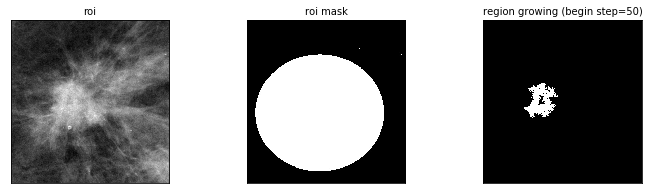

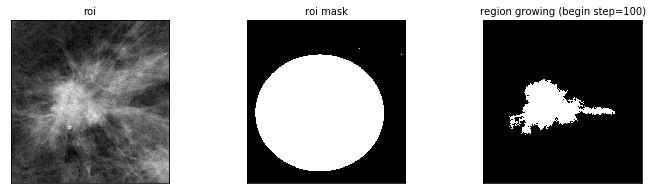

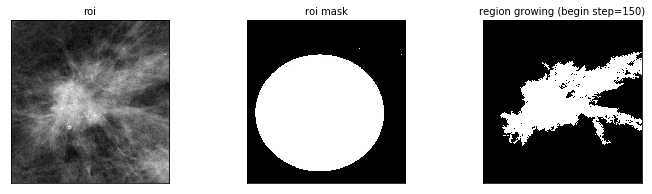

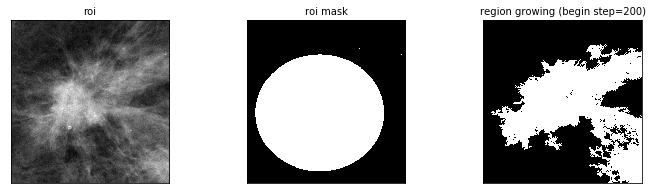

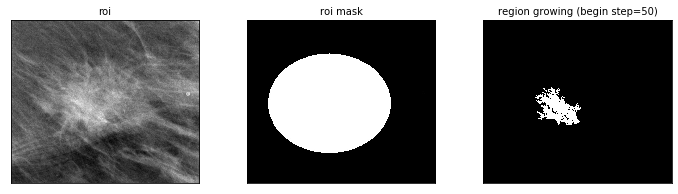

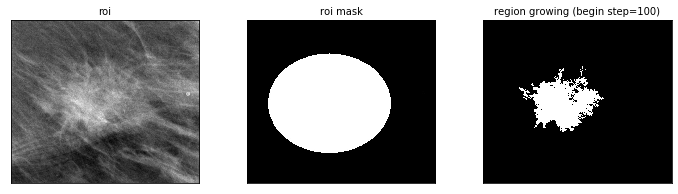

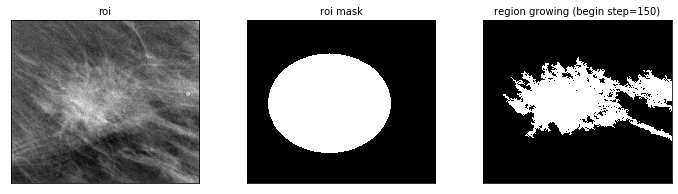

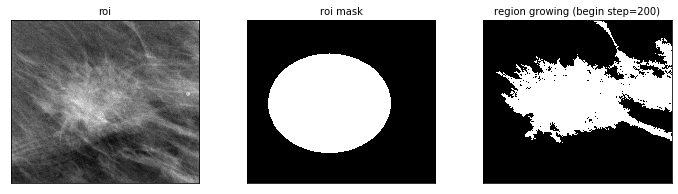

In [331]:
threshold = 10
for i in range(2): # mammograms with a mass
    for begin_step in [50,100,150,200]:
        roi = rois[i]
        roi_mask = rois_masks[i]
        roi = np.uint8(roi)
        new_mask = region_growing_mean(roi,begin_step=begin_step,seeds=[(250,200)],thresh=threshold)
        titles = ['roi','roi mask','region growing (begin step='+str(begin_step)+')']
        fig = plt.figure(figsize=(12, 3))
        for n, a in enumerate([roi,roi_mask,new_mask]):
            ax = fig.add_subplot(1, 3,n + 1)
            ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
            ax.set_title(titles[n], fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
        #fig.tight_layout()
        plt.show()

Inspired by Fan, Minjie & Lee, Thomas. (2015). Variants of Seeded Region Growing. IET Image Processing. 9. 10.1049/iet-ipr.2014.0490., we try to improve our previous region growing implementation.

The idea is to not only look at the neighboring pixels but a larger area around each candidata pixel.

In [343]:
def region_growing_zone(image,step=3,seeds=None,thresh=10):
    d = [(1,1),(0,1),(1,0),(-1,0),(1,-1),(0,-1),(-1,1),(-1,-1)]
    #d = [(step,step),(0,step),(step,0),(-step,0),(step,-step),(0,-step),(-step,step),(-step,-step)]
    """
    Apply region growing by looking at an area (square of length 2*step) around the pixel of interest of , starting from the seeds
    input :
    image is a numpy array representing a graycale image
    step half length of the zone 
    seeds is a list of tuple representing coordinates in the image
    thresh is a threshold on the difference of pixel intensity between neighbours
    output :
    mask is a numpy array of the size of image and representing the computed segmentation mask
    """
    height, width = image.shape
    mask = np.zeros((height,width))
    m = np.mean(image)
    seedsList = []
    for seed in seeds:
        seedsList.append(seed)
    while len(seedsList) > 0:
        new_seed = seedsList.pop(0)
        
        mask[new_seed[0],new_seed[1]]=1
        if new_seed[0]+step<height and new_seed[1]+step<width:
            for disp in d:
                new_y = new_seed[0]+disp[0]
                new_x = new_seed[1]+disp[1]
                if (not (0<=new_y<height and 0<=new_x<width)) or mask[new_y][new_x]==1 or np.mean(image[max(0,new_y-step):min(height,new_y+step),max(0,new_x-step):min(width,new_x+step)]) <m:
                    continue
                
                diff = abs(np.mean(image[max(0,new_seed[0]-step):min(height,new_seed[0]+step),max(0,new_seed[1]-step):min(width,new_seed[1]+step)])-np.mean(image[max(0,new_y-step):min(height,new_y+step),max(0,new_x-step):min(width,new_x+step)]))
                
                if diff < thresh:
                    mask[new_y,new_x]=1
                    seedsList.append((new_y,new_x))
    return mask

Again, it seems to help to reduce small leaks but not the large ones.

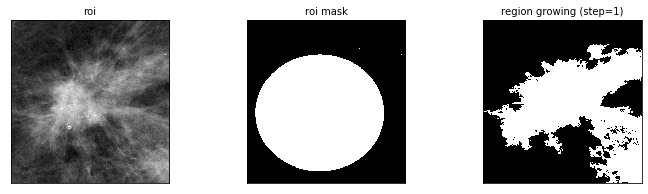

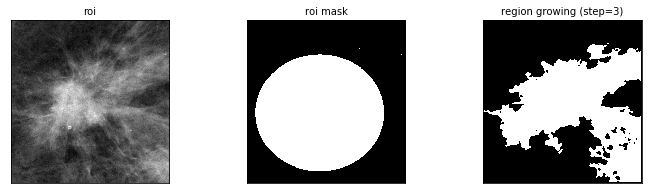

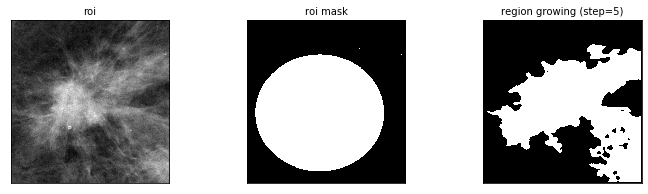

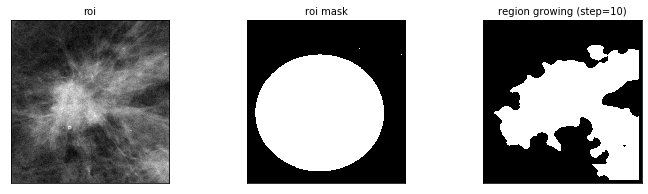

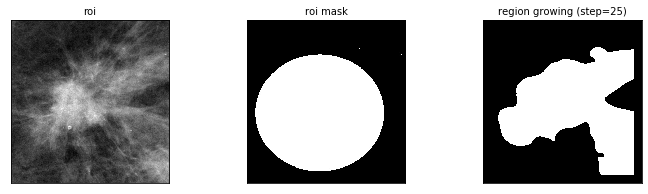

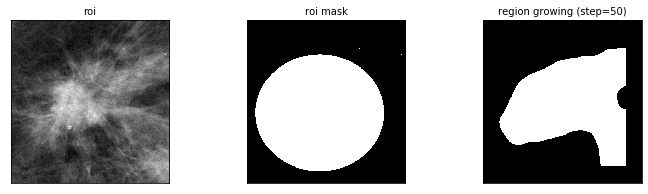

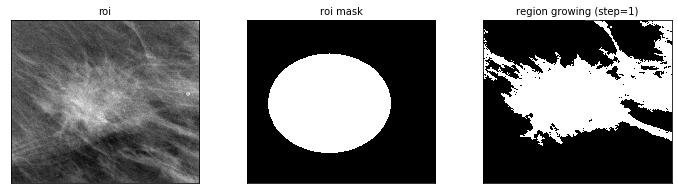

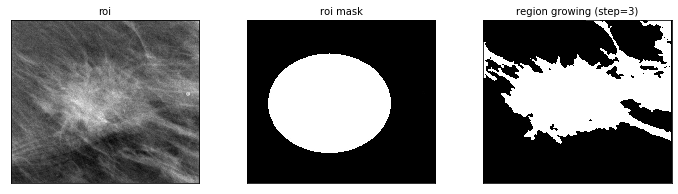

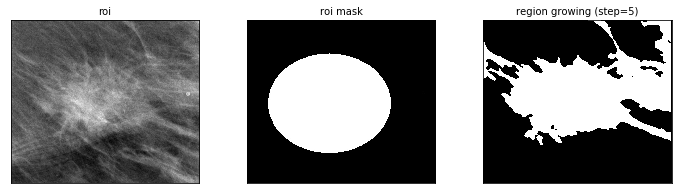

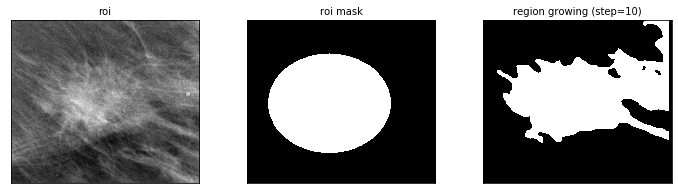

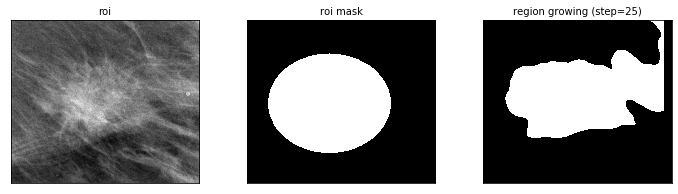

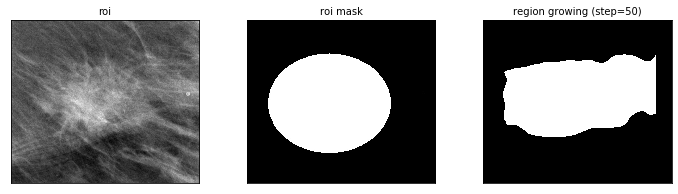

In [346]:
threshold = 10
for i in range(2): # mammograms with a mass
    for step in [1,3,5,10,25,50]:
        roi = rois[i]
        roi_mask = rois_masks[i]
        roi = np.uint8(roi)
        new_mask = region_growing_zone(roi,step=step,seeds=[(250,200)],thresh=threshold)
        titles = ['roi','roi mask','region growing (step='+str(step)+')']
        fig = plt.figure(figsize=(12, 3))
        for n, a in enumerate([roi,roi_mask,new_mask]):
            ax = fig.add_subplot(1, 3,n + 1)
            ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
            ax.set_title(titles[n], fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
        #fig.tight_layout()
        plt.show()

Finally, we combine all these ideas in a final region growing algorithm with the opening operator.

In [347]:
def region_growing_final(image,begin_step=5,step=3,seeds=None,thresh=10):
    d = [(1,1),(0,1),(1,0),(-1,0),(1,-1),(0,-1),(-1,1),(-1,-1)]
    """
    Apply region growing by looking at an area (square of length 2*step) around the pixel of interest of , starting from the seeds
    input :
    image is a numpy array representing a graycale image
    step half length of the zone 
    seeds is a list of tuple representing coordinates in the image
    thresh is a threshold on the difference of pixel intensity between neighbours
    output :
    mask is a numpy array of the size of image and representing the computed segmentation mask
    """
    height, width = image.shape
    mask = np.zeros((height,width))
    mean_area = 0
    seedsList = []
    
    for seed in seeds:
        seedsList.append(seed)
        mean_area += np.mean(image[seed[0]-begin_step:seed[0]+begin_step,seed[1]-begin_step:seed[1]+begin_step])
    mean_area = mean_area/len(seeds)
    while len(seedsList) > 0:
        new_seed = seedsList.pop(0)
        
        mask[new_seed[0],new_seed[1]]=1
        if new_seed[0]+step<height and new_seed[1]+step<width:
            for disp in d:
                new_y = new_seed[0]+disp[0]
                new_x = new_seed[1]+disp[1]
                if (not (0<=new_y<height and 0<=new_x<width)) or mask[new_y][new_x]==1 or np.mean(image[max(0,new_y-step):min(height,new_y+step),max(0,new_x-step):min(width,new_x+step)]) <mean_area:
                    continue
                
                diff = abs(np.mean(image[max(0,new_seed[0]-step):min(height,new_seed[0]+step),max(0,new_seed[1]-step):min(width,new_seed[1]+step)])-np.mean(image[max(0,new_y-step):min(height,new_y+step),max(0,new_x-step):min(width,new_x+step)]))
                
                if diff < thresh:
                    mask[new_y,new_x]=1
                    seedsList.append((new_y,new_x))
    return mask

In [1]:
threshold = 1
begin_step = 150
step = 2
for i in range(2): # mammograms with a mass
    for size in [(1,1),(5,5),(11,11),(49,49)]:
        roi = rois[i]
        blur = cv.GaussianBlur(roi,size,sigmaX=10)
        roi_mask = rois_masks[i]
        new_mask = region_growing_final(blur,begin_step=begin_step,step=step,seeds=[(250,200)],thresh=threshold)
        mask_opening = opening(new_mask,kernel_size=(10,10))
        titles = ['roi','roi mask','region growing with blurring (kernel size='+str(size)+')','after opening']
        fig = plt.figure(figsize=(12, 3))
        for n, a in enumerate([roi,roi_mask,new_mask,mask_opening]):
            ax = fig.add_subplot(1, 4,n + 1)
            ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
            ax.set_title(titles[n], fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
        #fig.tight_layout()
        plt.show()

NameError: name 'rois' is not defined

# Chapter 4 : Further work and thoughts

#### Step 1 : Docker
To

# Conclusion